In [39]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, auc, roc_curve

In [40]:
#droping columns, shape 
heart_data= pd.read_csv('logregtaskPY.csv')
heart_data.drop('education', axis=1, inplace=True)
heart_data.drop('currentSmoker', axis=1, inplace=True)
heart_data.drop('sysBP', axis=1, inplace=True)
heart_data.drop('diaBP', axis=1, inplace=True)
print('Heart data shape:', heart_data.shape)

Heart data shape: (4238, 12)


In [41]:
# Fill missing values for 'BMI', 'BPMeds', and 'totChol' with median
imputer = SimpleImputer(strategy='median')
heart_data[['BMI', 'BPMeds', 'totChol', 'cigsPerDay', 'heartRate']] = imputer.fit_transform(heart_data[['BMI', 'BPMeds', 'totChol', 'cigsPerDay', 'heartRate']])

# Replace NaN values in 'glucose' column with mean of respective groups defined by 'diabetes'

heart_data.loc[:, 'glucose'] = heart_data.groupby('diabetes')['glucose'].transform(lambda x: x.fillna(x.median()))

In [42]:
#deleting extreeme values from totChol and BMI
column1='totChol'
column2='BMI'
chol=500
bmi=50
heart_data_del= heart_data[(heart_data[column1]>chol) | (heart_data[column2]>bmi)].index
heart_data.drop(heart_data_del, inplace = True)

In [43]:
#create a variable overweight
#overweight cut off 25, 0 - normal, 1 - overweight
overweight_cutoff = 25.0 
heart_data.loc[:,'overweight']=(heart_data['BMI']> overweight_cutoff).astype (int)
heart_data.drop('BMI', axis=1, inplace= True)
heart_data.drop('diabetes', axis=1, inplace = True)
print(heart_data.shape)
heart_data.head()

(4234, 11)


,male,age,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,totChol,heartRate,glucose,TenYearCHD,overweight
0,1,39,0.0,0.0,0,0,195.0,80.0,77.0,0,1
1,0,46,0.0,0.0,0,0,250.0,95.0,76.0,0,1
2,1,48,20.0,0.0,0,0,245.0,75.0,70.0,0,1
3,0,61,30.0,0.0,0,1,225.0,65.0,103.0,1,1
4,0,46,23.0,0.0,0,0,285.0,85.0,85.0,0,0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Axes: xlabel='glucose', ylabel='Count'>

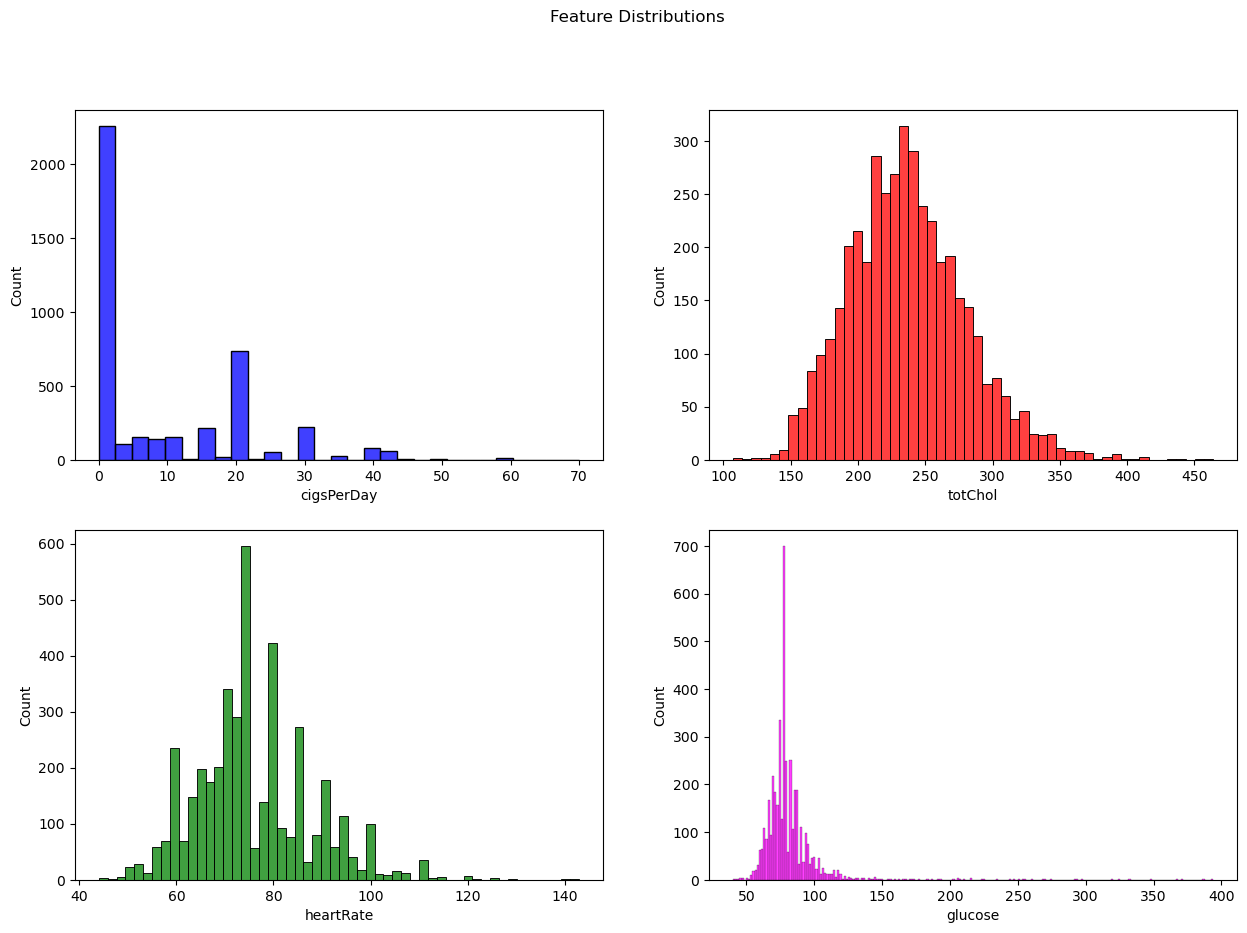

In [44]:
# Histogram for continuous features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.suptitle('Feature Distributions')
sns.histplot(heart_data['cigsPerDay'], kde=False, color="blue", ax=axes[0,0])
sns.histplot(heart_data['totChol'], kde=False, color="red", ax=axes[0,1])
sns.histplot(heart_data['heartRate'], kde=False, color="green", ax=axes[1,0])
sns.histplot(heart_data['glucose'], kde=False, color="magenta", ax=axes[1,1])

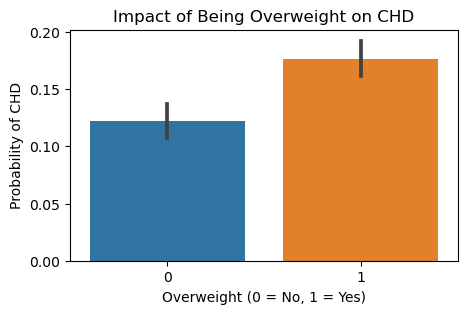

In [45]:
# Bar plot for the 'overweight' feature impact on CHD
plt.figure(figsize=(5, 3))
sns.barplot(x='overweight', y='TenYearCHD', data=heart_data)
plt.title('Impact of Being Overweight on CHD')
plt.ylabel('Probability of CHD')
plt.xlabel('Overweight (0 = No, 1 = Yes)')
plt.show()

In [46]:
# split X and y into training and testing sets
X = heart_data.drop(['TenYearCHD'], axis = 1)
y = heart_data['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Identify continuous variables
continuous_cols = ['cigsPerDay', 'totChol', 'heartRate', 'glucose']

# Standardizing continuous features
scaler = StandardScaler()
X_train_scaled_cont = X_train.copy()
X_test_scaled_cont = X_test.copy()

X_train_scaled_cont[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled_cont[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Concatenate standardized continuous features with categorical features
X_train_scaled = pd.concat([X_train_scaled_cont, X_train.drop(continuous_cols, axis=1)], axis=1)
X_test_scaled = pd.concat([X_test_scaled_cont, X_test.drop(continuous_cols, axis=1)], axis=1)

# Applying SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Creating a logistic regression model
logistic_reg_model = LogisticRegression(max_iter=10000, solver='saga')

# Training the model on the oversampled data
logistic_reg_model.fit(X_train_resampled, y_train_resampled)

# Making predictions on the test set
y_pred = logistic_reg_model.predict(X_test_scaled)

In [47]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nF1 Score:", f1)

Accuracy: 0.6552538370720189

Confusion Matrix:
 [[467 244]
 [ 48  88]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.66      0.76       711
           1       0.27      0.65      0.38       136

    accuracy                           0.66       847
   macro avg       0.59      0.65      0.57       847
weighted avg       0.80      0.66      0.70       847


F1 Score: 0.37606837606837606


In [48]:
# Calculating the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg_model.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

print("\nROC AUC Score:", roc_auc)


ROC AUC Score: 0.7187991230247374


In [49]:
from collections import Counter
from sklearn.datasets import make_classification

# Count occurrences of each class in the oversampled target
class_counts = Counter(y_train_resampled)
print("Counts per class after SMOTE:", class_counts)

Counts per class after SMOTE: Counter({0: 2881, 1: 2881})


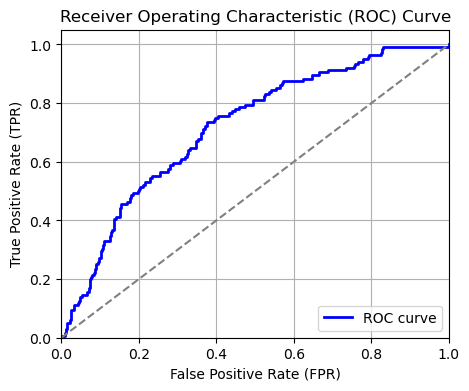

In [50]:
# Plot ROC curve
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Confusion Matrix:
 [[467 244]
 [ 48  88]]


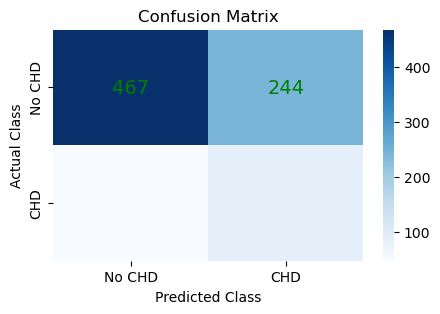

In [51]:
# Confusion Matrix Heatmap
# Ensure the confusion matrix is of integer type
conf_matrix = np.array(conf_matrix, dtype=int)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            annot_kws={"color": "green", "ha": 'center', "va": 'center', "size": 14},  # Adjust size here
            xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
print("\nConfusion Matrix:\n", conf_matrix)


In [52]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.408289
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: TenYearCHD       Pseudo R-squared: 0.041     
Date:               2024-06-11 09:55 AIC:              3477.3939 
No. Observations:   4234             BIC:              3540.9029 
Df Model:           9                Log-Likelihood:   -1728.7   
Df Residuals:       4224             LL-Null:          -1801.7   
Converged:          1.0000           LLR p-value:      6.0614e-27
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
male              0.1457   0.0934   1.5592 0.1189 -0.0374  0.3288
age               0.0217   0.0048   4.5560 0.0000  0.0124  0.0311
